This notebook processes all the data in *datathon_2024_dataset_corrected.csv* into a dataset that relates the outcome of each game to the team's short-term travel history preceding the game.

In [1]:
import numpy as np
import pandas as pd
from geopy.distance import distance as geodist
from tqdm import tqdm
import itertools as itr
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('.data/datathon_2024_dataset_corrected.csv')
df["date"] = pd.to_datetime(df["game_date"], format='%Y%m%d')
df = df[['date', 'home_team', 'away_team', 'is_day_game', 'home_score', 'away_score', 'venue_name']]
print(df.head())

        date home_team away_team  is_day_game  home_score  away_score  \
0 2000-03-29       NYN       CHN        False           3           5   
1 2000-03-30       CHN       NYN        False           1           5   
2 2000-04-03       ATL       COL         True           2           0   
3 2000-04-03       CIN       MIL         True           3           3   
4 2000-04-03       FLO       SFN        False           6           4   

         venue_name  
0        Tokyo Dome  
1        Tokyo Dome  
2      Turner Field  
3     Cinergy Field  
4  Sun Life Stadium  


In [3]:
venue_df = pd.read_csv('.data/venue.csv', index_col='venue_name')
print(venue_df.head())

                     lat     long
venue_name                       
Tokyo Dome        35.705  139.752
Turner Field      33.735  -84.389
Cinergy Field     39.548  -84.303
Sun Life Stadium  25.959  -80.240
Stade Olympique   45.558  -73.552


In [4]:
ratings_df = pd.read_csv('.data/ratings.csv', index_col=0)
print(ratings_df.head())

              NYN          CHN          ATL         CIN          FLO  \
2000  1038.017188   917.678828  1042.674724  997.844659   966.687400   
2001  1005.592796  1026.929246  1018.058941  924.181293   978.822684   
2002   987.941045   927.809848  1082.079387  977.270124   993.957073   
2003   966.341535  1029.857521  1099.373832  953.859508  1062.951834   
2004   957.956335  1039.445100  1051.894527  995.447553  1005.446032   

              MON          SLN          ANA         BAL          MIN  ...  \
2000   912.845077  1041.235203  1015.696564  967.604105   946.956321  ...   
2001   931.993227  1038.864909  1012.488507  929.048103  1026.780353  ...   
2002  1019.348446  1061.354864  1088.919223  951.939834  1034.855708  ...   
2003  1023.528184  1030.376459   972.777884  956.184437  1005.573792  ...   
2004   919.790092  1107.615123  1051.390657  984.328987  1020.424621  ...   

              SDN          SFN          BOS         DET          NYA  \
2000   969.552464  1040.555750  

In [5]:
years = df['date'].dt.year.unique()
years.sort()
print(years)

[2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023]


In [6]:
teams = df['home_team'].unique()
teams.sort()
print(teams)

['ANA' 'ARI' 'ATL' 'BAL' 'BOS' 'CHA' 'CHN' 'CIN' 'CLE' 'COL' 'DET' 'FLO'
 'HOU' 'KCA' 'LAN' 'MIA' 'MIL' 'MIN' 'MON' 'NYA' 'NYN' 'OAK' 'PHI' 'PIT'
 'SDN' 'SEA' 'SFN' 'SLN' 'TBA' 'TEX' 'TOR' 'WAS']


In [7]:
opening_day = {yr : df['date'][df['date'].dt.year == yr].min() for yr in years}

df['day'] = 0
for ind in tqdm(df.index):
    df.loc[ind, 'day'] = (df.loc[ind, 'date'] - opening_day[df.loc[ind, 'date'].year]).days

print(df.head())

100%|█| 56775/56775 [

        date home_team away_team  is_day_game  home_score  away_score  \
0 2000-03-29       NYN       CHN        False           3           5   
1 2000-03-30       CHN       NYN        False           1           5   
2 2000-04-03       ATL       COL         True           2           0   
3 2000-04-03       CIN       MIL         True           3           3   
4 2000-04-03       FLO       SFN        False           6           4   

         venue_name  day  
0        Tokyo Dome    0  
1        Tokyo Dome    1  
2      Turner Field    5  
3     Cinergy Field    5  
4  Sun Life Stadium    5  


In [8]:
homes = pd.DataFrame(data="", index=years, columns=teams)
for ind in tqdm(df.index):
    home_team = df.loc[ind, 'home_team']
    yr = df.loc[ind, 'date'].year
    venue = df.loc[ind, 'venue_name']
    homes.loc[yr, home_team] = venue
print(homes)

100%|█| 56775/56775 [

                           ANA          ARI           ATL  \
2000  Angel Stadium of Anaheim  Chase Field  Turner Field   
2001  Angel Stadium of Anaheim  Chase Field  Turner Field   
2002  Angel Stadium of Anaheim  Chase Field  Turner Field   
2003  Angel Stadium of Anaheim  Chase Field  Turner Field   
2004  Angel Stadium of Anaheim  Chase Field  Turner Field   
2005  Angel Stadium of Anaheim  Chase Field  Turner Field   
2006  Angel Stadium of Anaheim  Chase Field  Turner Field   
2007  Angel Stadium of Anaheim  Chase Field  Turner Field   
2008  Angel Stadium of Anaheim  Chase Field  Turner Field   
2009  Angel Stadium of Anaheim  Chase Field  Turner Field   
2010  Angel Stadium of Anaheim  Chase Field  Turner Field   
2011  Angel Stadium of Anaheim  Chase Field  Turner Field   
2012  Angel Stadium of Anaheim  Chase Field  Turner Field   
2013  Angel Stadium of Anaheim  Chase Field  Turner Field   
2014  Angel Stadium of Anaheim  Chase Field  Turner Field   
2015  Angel Stadium of A

In [9]:
days = list(np.arange(0, df['day'].max()+1, 1))
print(days)

extended_days = [-1] + list(days) + [days[-1]+1]
print(extended_days)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 

In [10]:
location = {team:
                {year:
                    {day:
                         {'home': 0,
                          'away': 0,
                          'travel': 0,
                          'miles': 0,
                          'daygame': 0,
                          'venue': None,
                          'won': 0,
                          'odds': np.nan,
                          'expected': np.nan}
                     for day in extended_days
                    }
                for year in years
                }
            for team in teams
            }

for team in teams:
    for yr in years:
        home_venue = homes.loc[yr, team]
        if home_venue is None:
            print(team, yr)
            del location[team][yr]
        else:
            location[team][yr][-1]['venue'] = home_venue
            location[team][yr][days[-1]+1]['venue'] = home_venue

In [11]:
for ind in tqdm(df.index):
    home_team = df.loc[ind, 'home_team']
    away_team = df.loc[ind, 'away_team']
    home_score = df.loc[ind, 'home_score']
    away_score = df.loc[ind, 'away_score']
    yr = df.loc[ind, 'date'].year
    day = df.loc[ind, 'day']
    daygame = df.loc[ind, 'is_day_game']
    venue = df.loc[ind, 'venue_name']
    home_rate = ratings_df.loc[yr, home_team]
    away_rate = ratings_df.loc[yr, away_team]

    location[home_team][yr][day]['home'] = 1
    location[away_team][yr][day]['away'] = 1    
    if daygame:
        location[home_team][yr][day]['daygame'] = 1
        location[away_team][yr][day]['daygame'] = 1
    location[home_team][yr][day]['venue'] = venue
    location[away_team][yr][day]['venue'] = venue
    if home_score == away_score:
        location[home_team][yr][day]['won'] = 0.5
        location[away_team][yr][day]['won'] = 0.5
    elif home_score > away_score:
        location[home_team][yr][day]['won'] = 1
    else:
        location[away_team][yr][day]['won'] = 1

    location[home_team][yr][day]['odds'] = 10 ** ((home_rate - away_rate) / 400)
    location[away_team][yr][day]['odds'] = 10 ** ((away_rate - home_rate) / 400)

    location[home_team][yr][day]['expected'] = 1 / (1 + 10 ** ((away_rate - home_rate) / 400))
    location[away_team][yr][day]['expected'] = 1 / (1 + 10 ** ((home_rate - away_rate) / 400))

100%|█| 56775/56775 [


In [12]:
for team in teams:
    for yr in years:
        for day in reversed(days):
            if location[team][yr][day]['venue'] is None:
                location[team][yr][day]['venue'] = location[team][yr][day+1]['venue']
        for day in extended_days[1:]:
            yesterday_venue = location[team][yr][day-1]['venue']
            today_venue = location[team][yr][day]['venue']
            if yesterday_venue != today_venue:
                location[team][yr][day]['travel'] = 1
                location[team][yr][day]['miles'] = geodist(venue_df.loc[yesterday_venue].tolist(), venue_df.loc[today_venue].tolist()).miles
        if sum([location[team][yr][dummy_day]['won'] for dummy_day in days]) == 0:
            del location[team][yr]

In [13]:
MAX_DELAY = 7

var_names = ['win', 'odds', 'expected'] + [f'{var}{delay}' for var, delay in itr.product(['home', 'away', 'daygame', 'travel', 'miles'], range(MAX_DELAY))]

ind_names = []
for team in teams:
    for yr in location[team].keys():
        for day in days:
            ind_names.append(f'{team}{yr}{day}')

In [14]:
ml_dict = {ind: {} for ind in ind_names}
for team in tqdm(teams):
    for yr in location[team].keys():
        for day in days:
            ind = f'{team}{yr}{day}'
            ml_dict[ind]['won'] = location[team][yr][day]['won']
            ml_dict[ind]['odds'] = location[team][yr][day]['odds']
            ml_dict[ind]['expected'] = location[team][yr][day]['expected']
            for delay_day in range(day, min(day + MAX_DELAY, days[-1]+1)):
                delay_ind = f'{team}{yr}{delay_day}'
                for var in ['home', 'away', 'daygame', 'travel', 'miles']:
                    var_name = f'{var}{delay_day-day}'
                    ml_dict[delay_ind][var_name] = location[team][yr][day][var]
ml_df = pd.DataFrame(ml_dict).transpose()
ml_df = ml_df.dropna()
print(ml_df.iloc[:20, ])
print(ml_df.shape)

100%|█| 32/32 [00:02<


           won      odds  expected  home0  away0  daygame0  travel0  \
ANA20006   0.0  0.911570  0.476870    1.0    0.0       0.0      0.0   
ANA20007   1.0  0.911570  0.476870    1.0    0.0       0.0      0.0   
ANA20009   1.0  0.910219  0.476500    1.0    0.0       0.0      0.0   
ANA200010  1.0  0.910219  0.476500    1.0    0.0       0.0      0.0   
ANA200011  0.0  0.910219  0.476500    1.0    0.0       1.0      0.0   
ANA200012  1.0  1.060365  0.514649    1.0    0.0       0.0      0.0   
ANA200013  1.0  1.060365  0.514649    1.0    0.0       0.0      0.0   
ANA200014  0.0  1.060365  0.514649    1.0    0.0       0.0      0.0   
ANA200016  0.0  0.775286  0.436711    0.0    1.0       0.0      0.0   
ANA200017  1.0  0.775286  0.436711    0.0    1.0       1.0      0.0   
ANA200018  1.0  0.775286  0.436711    0.0    1.0       1.0      0.0   
ANA200019  0.0  1.060365  0.514649    0.0    1.0       0.0      1.0   
ANA200020  1.0  1.060365  0.514649    0.0    1.0       0.0      0.0   
ANA200

In [15]:
ml_df.to_csv('.data/logregression_data.csv')

C:\Users\georg\OneDrive\Documents\Rice University\Projects\Datathon 2024\MLB-Schedule-Morale\.venv_datathon2024\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\georg\OneDrive\Documents\Rice University\Projects\Datathon 2024\MLB-Schedule-Morale\.venv_datathon2024\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\georg\OneDrive\Documents\Rice University\Projects\Datathon 2024\MLB-Schedule-Morale\.venv_datathon2024\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, 

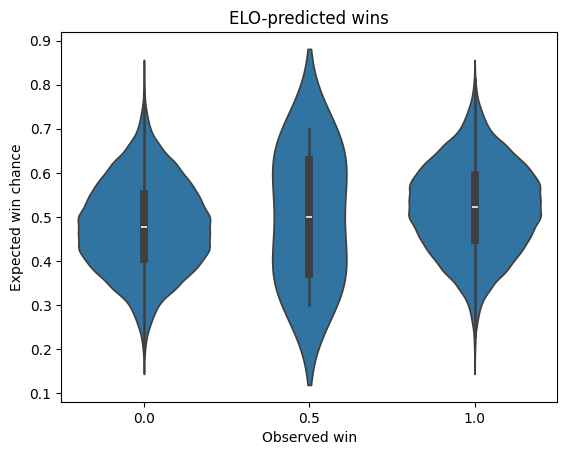

In [16]:
sns.violinplot(x=ml_df['won'].astype(float), y=ml_df['expected'])
plt.xlabel('Observed win')
plt.ylabel('Expected win chance')
plt.title('ELO-predicted wins')
plt.show()

In [17]:
corr = np.corrcoef(ml_df[['won', 'expected', 'odds']].astype(float).transpose())
print(corr)
print(corr ** 2)

[[1.         0.20447649 0.19500906]
 [0.20447649 1.         0.95304354]
 [0.19500906 0.95304354 1.        ]]
[[1.         0.04181064 0.03802854]
 [0.04181064 1.         0.90829199]
 [0.03802854 0.90829199 1.        ]]
